# Day 6: Ensemble Stacking for Trading

## 🎯 Learning Objectives
- Understand stacking ensemble methods
- Build multi-level meta-learners
- Combine diverse models
- Prevent information leakage

---

## 📚 Theory: Stacking

### Ensemble Methods Comparison

| Method | How It Works |
|--------|-------------|
| Bagging | Train parallel, average predictions |
| Boosting | Train sequential, focus on errors |
| Stacking | Train meta-model on base model predictions |

### Stacking Architecture
```
Level 0 (Base Models):
├── Model 1 (e.g., XGBoost) → predictions_1
├── Model 2 (e.g., LightGBM) → predictions_2
├── Model 3 (e.g., Random Forest) → predictions_3
└── Model 4 (e.g., Logistic) → predictions_4

Level 1 (Meta-Model):
└── Meta-Model (e.g., Logistic) → final prediction
    Input: [predictions_1, predictions_2, predictions_3, predictions_4]
```

### Preventing Data Leakage
- Use **out-of-fold** predictions for training meta-model
- K-fold cross-validation on training data
- Each sample gets prediction from model trained without it

### Key Principles
1. **Diversity**: Base models should be different
2. **Quality**: Each base model should have reasonable performance
3. **Correlation**: Lower correlation between predictions is better

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
volume = data['Volume']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [2]:
# Create features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum
for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

df['volume_ratio'] = volume / volume.rolling(20).mean()
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Target
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Samples: {len(df)}")

📊 Samples: 1233


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

# Scale for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 986, Test: 247


In [4]:
# Define base models (diverse!)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss')),
    ('lgbm', lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbosity=-1)),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=10))
]

# Train base models and get test predictions
print("\n" + "="*70)
print("BASE MODEL PERFORMANCE")
print("="*70)

base_predictions = {}
base_probabilities = {}

print(f"\n{'Model':<15} {'Test Acc':>12} {'Test F1':>12} {'AUC':>12}")
print("-" * 55)

for name, model in base_models:
    # Use scaled data for Logistic and KNN
    if name in ['logistic', 'knn']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    base_predictions[name] = y_pred
    base_probabilities[name] = y_proba
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name:<15} {acc:>12.2%} {f1:>12.2%} {auc:>12.4f}")


BASE MODEL PERFORMANCE

Model               Test Acc      Test F1          AUC
-------------------------------------------------------
rf                    54.25%       63.90%       0.5514
xgb                   52.23%       55.97%       0.5576
lgbm                  57.89%       63.12%       0.5780
logistic              54.25%       64.58%       0.5549
knn                   51.42%       47.83%       0.5325


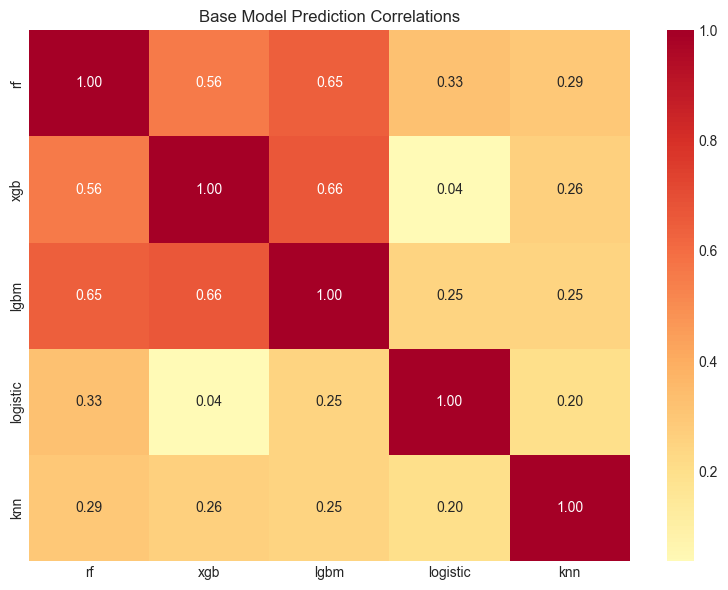


💡 Lower correlation = More diverse models = Better ensemble


In [5]:
# Check correlation between base model predictions
pred_df = pd.DataFrame(base_probabilities)
corr_matrix = pred_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn_r', center=0, fmt='.2f')
plt.title('Base Model Prediction Correlations')
plt.tight_layout()
plt.show()

print("\n💡 Lower correlation = More diverse models = Better ensemble")

In [6]:
# Method 1: Simple Averaging (Soft Voting)
avg_proba = np.mean([base_probabilities[name] for name in base_probabilities], axis=0)
avg_pred = (avg_proba > 0.5).astype(int)

print("\n" + "="*60)
print("SIMPLE AVERAGING ENSEMBLE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, avg_pred):.2%}")
print(f"F1: {f1_score(y_test, avg_pred):.2%}")
print(f"AUC: {roc_auc_score(y_test, avg_proba):.4f}")


SIMPLE AVERAGING ENSEMBLE
Accuracy: 52.63%
F1: 58.36%
AUC: 0.5730


In [7]:
# Method 2: Manual Stacking with Out-of-Fold Predictions
tscv = TimeSeriesSplit(n_splits=5)

# Generate out-of-fold predictions for each base model
print("\n⏳ Generating out-of-fold predictions...")

oof_predictions = np.zeros((len(X_train), len(base_models)))
test_predictions = np.zeros((len(X_test), len(base_models)))

for i, (name, model) in enumerate(base_models):
    # Use scaled data for Logistic and KNN
    if name in ['logistic', 'knn']:
        oof = cross_val_predict(model, X_train_scaled, y_train, cv=tscv, method='predict_proba')[:, 1]
        model.fit(X_train_scaled, y_train)
        test_pred = model.predict_proba(X_test_scaled)[:, 1]
    else:
        oof = cross_val_predict(model, X_train, y_train, cv=tscv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        test_pred = model.predict_proba(X_test)[:, 1]
    
    oof_predictions[:, i] = oof
    test_predictions[:, i] = test_pred
    print(f"✅ {name} done")

print(f"\nOOF predictions shape: {oof_predictions.shape}")


⏳ Generating out-of-fold predictions...


ValueError: cross_val_predict only works for partitions

In [ ]:
# Train meta-model on out-of-fold predictions
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(oof_predictions, y_train)

# Final predictions
stacked_pred = meta_model.predict(test_predictions)
stacked_proba = meta_model.predict_proba(test_predictions)[:, 1]

print("\n" + "="*60)
print("STACKING ENSEMBLE (Out-of-Fold)")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, stacked_pred):.2%}")
print(f"F1: {f1_score(y_test, stacked_pred):.2%}")
print(f"AUC: {roc_auc_score(y_test, stacked_proba):.4f}")

# Meta-model coefficients
print("\nMeta-model weights:")
for name, coef in zip([n for n, _ in base_models], meta_model.coef_[0]):
    print(f"  {name}: {coef:.4f}")

In [ ]:
# Method 3: sklearn StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss')),
        ('lgbm', lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbosity=-1))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=TimeSeriesSplit(n_splits=3),
    stack_method='predict_proba'
)

print("\n⏳ Training sklearn StackingClassifier...")
stacking_clf.fit(X_train, y_train)

sklearn_pred = stacking_clf.predict(X_test)
sklearn_proba = stacking_clf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("sklearn StackingClassifier")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, sklearn_pred):.2%}")
print(f"F1: {f1_score(y_test, sklearn_pred):.2%}")
print(f"AUC: {roc_auc_score(y_test, sklearn_proba):.4f}")

In [ ]:
# Compare all ensemble methods
print("\n" + "="*70)
print("ENSEMBLE METHODS COMPARISON")
print("="*70)

ensemble_results = [
    ('Simple Averaging', avg_pred, avg_proba),
    ('Manual Stacking', stacked_pred, stacked_proba),
    ('sklearn Stacking', sklearn_pred, sklearn_proba)
]

print(f"\n{'Method':<20} {'Accuracy':>12} {'F1':>12} {'AUC':>12}")
print("-" * 60)

for name, pred, proba in ensemble_results:
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    print(f"{name:<20} {acc:>12.2%} {f1:>12.2%} {auc:>12.4f}")

In [ ]:
# Trading Strategy Backtest - Compare Ensembles
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# Add all strategies
strategies_data = [
    ('Simple Avg', avg_pred, avg_proba),
    ('Stacking', stacked_pred, stacked_proba),
    ('Best Base (XGBoost)', base_predictions['xgb'], base_probabilities['xgb'])
]

for name, pred, proba in strategies_data:
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '')
    backtest[f'{safe_name}_signal'] = pred
    backtest[f'{safe_name}_return'] = pred * backtest['actual_return']
    backtest[f'{safe_name}_cum'] = (1 + backtest[f'{safe_name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['Simple_Avg_cum'], label='Simple Averaging', linewidth=2)
plt.plot(backtest.index, backtest['Stacking_cum'], label='Stacking', linewidth=2)
plt.plot(backtest.index, backtest['Best_Base_XGBoost_cum'], label='XGBoost (Best Base)', linewidth=2, linestyle='--')
plt.title(f'Ensemble Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Performance Summary
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'actual_return', 'buy_hold_cum'),
    ('Simple Averaging', 'Simple_Avg_return', 'Simple_Avg_cum'),
    ('Stacking', 'Stacking_return', 'Stacking_cum'),
    ('XGBoost (Base)', 'Best_Base_XGBoost_return', 'Best_Base_XGBoost_cum')
]

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[cum_col])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")

In [ ]:
# Next day prediction with ensemble
print("\n" + "="*60)
print(f"📊 NEXT DAY ENSEMBLE PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

# Stacking prediction
latest_test_pred = test_predictions[-1:]
stack_pred = meta_model.predict(latest_test_pred)[0]
stack_proba = meta_model.predict_proba(latest_test_pred)[0]

print(f"\nBase Model Votes:")
bullish = 0
for name, proba in base_probabilities.items():
    vote = '📈' if proba[-1] > 0.5 else '📉'
    bullish += 1 if proba[-1] > 0.5 else 0
    print(f"  {name}: {vote} ({proba[-1]:.1%})")

print(f"\nEnsemble (Stacking): {'📈 UP' if stack_pred == 1 else '📉 DOWN'}")
print(f"Probability: {stack_proba[1]:.2%}")
print(f"\n🎯 Consensus: {bullish}/{len(base_probabilities)} models bullish")

---

## 🏢 Real-World Applications

| Company | Stacking Use Case |
|---------|------------------|
| Kaggle | Competition winning strategy |
| Netflix | Recommendation ensemble |
| Two Sigma | Alpha combination |
| Citadel | Multi-model systems |

### Key Interview Points
1. **Why stacking?** - Combines diverse model strengths
2. **Data leakage?** - Use out-of-fold predictions for meta-model
3. **Meta-model choice?** - Simple (Logistic) often works best
4. **Base model diversity?** - More important than individual accuracy

---
## 📅 Tomorrow: Week 7.1 Review